# Check Duplicates, Loops and Dead Ends
After balancing the models in 02_balancing_metabolic_models the models went into Frowins Macaw Scripts, i.e. doing macaw run (everything but dilution test because of runtime) in MACAW_Phase_1_tests and then using the results to fix exact and directionality duplicates. Now we can try to further use the macaw (and also memote) results to curate the models. Firstly, we continue we duplicates (reaction duplicates and then check metabolites because maybe deleting some reactions can already help if we can also delete metabolites). Dead-Ends and Loops (and maybe in this context also energy generating cycles) need to be examined afterwards.

# Imports

In [128]:
from cobra.io import read_sbml_model, write_sbml_model
import os
import pandas as pd
from collections import Counter
import random
import matplotlib.pyplot as plt
from cobra.manipulation.validate import check_mass_balance
from itertools import cycle
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
# Load SBML Models
models_path = "../Models/04_after_macaw_fixes/"
models_curation = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_curate")
    models_curation[name] = model

models_curation = {key: models_curation[key] for key in sorted(models_curation.keys())}  # sorts the dictionary alphabetically
AA1_curate, AA2_curate, AA3_curate, AA4_curate, AA5_curate, AA6_curate, AA7_curate = [models_curation[f"AA{i}_curate"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [3]:
# Load macaw Results
report_path = "../Reports/B_Macaw_after_Duplicate_removing/"
macaw = {}

for file in os.listdir(report_path):
    if file.endswith('.csv'):
        file_path = os.path.join(report_path, file)
        df_name = file.replace('.csv', '')
        macaw[df_name] = pd.read_csv(file_path)

macaw = {key: macaw[key] for key in sorted(macaw.keys())}
AA1_macaw, AA2_macaw, AA3_macaw, AA4_macaw, AA5_macaw, AA6_macaw, AA7_macaw = [macaw[f"AA{i}_curated_afterphase_1"] for i in range(1, 8)]

# Functions

In [4]:
def get_rxn(model, rxn_id, print_mass = False, print_GPR=False):
    rxn = model.reactions.get_by_id(rxn_id)
    charges = {met.id: met.charge for met in rxn.metabolites}
    masses = {met.id: met.formula for met in rxn.metabolites}
    gpr = rxn.gene_reaction_rule
    if print_mass and print_GPR:
        print(rxn, charges, masses, gpr)
    elif print_mass:
        print(rxn, charges, masses)
    elif print_GPR:
        print(rxn, charges)
        print(gpr)
    else:
        print(rxn, charges)

In [51]:
def get_rxn_unknown(rxn_id, print_mass = False, print_GPR=False):
    model_list = []
    gpr_list= []
    for model in models_curation.values():
        if rxn_id in model.reactions:
            model_list.append(model)
            gpr_list.append(model.reactions.get_by_id(rxn_id).gene_reaction_rule)

    print(f"{rxn_id} is found in: {[model.id for model in model_list]}")

    if model_list:
        get_rxn(model_list[0], rxn_id, print_mass)

    if print_GPR:
        print(f"all GPRs: {set(gpr_list)}")

In [6]:
def get_met(model, met_id, print_rxn = True):
    met = model.metabolites.get_by_id(met_id)
    rxns_id = [rxn.id for rxn in met.reactions]
    rxns = {rxn.id:model.reactions.get_by_id(rxn.id).reaction for rxn in met.reactions}
    print(f"{met.name} ({met.formula}, {met.charge})")
    if print_rxn:
        print(rxns)
    else:
        print(rxns_id)

In [7]:
def get_met_unknown(met_id):
    model_list = []
    rxn_list = []
    for model in models_curation.values():
        if met_id in model.metabolites:
            model_list.append(model)
            rxns = model.metabolites.get_by_id(met_id).reactions
            for rxn in rxns:
                rxn_list.append(rxn.id)

    met_name = ""
    if model_list:
        met_name = model_list[0].metabolites.get_by_id(met_id).name
    print(f"{met_id} ({met_name}) is found  models: {[model.id for model in model_list]} and in reactions: {set(rxn_list)}")

In [8]:
def check_delete(model, compare_list):
    if len(compare_list) != 2:
        print("Please provide exactly two reactions to compare")
        return

    if compare_list[0] in model.reactions and compare_list[1] in model.reactions:
        rxn1 = model.reactions.get_by_id(compare_list[0])
        rxn2 = model.reactions.get_by_id(compare_list[1])

        if rxn1.gene_reaction_rule == rxn2.gene_reaction_rule:
            print(f"Same GPR for both reactions: {rxn1.gene_reaction_rule}")
        else:
            print(f"different GPR for both reactions: {rxn1.gene_reaction_rule} for {compare_list[0]} vs. {rxn2.gene_reaction_rule} for {compare_list[1]}")
    else:
        print("Not all reactions are in the model")

In [9]:
def overwrite_charge(model, rxn_id, new_charge):
    if rxn_id in model.metabolites:
        model.metabolites.get_by_id(rxn_id).charge = new_charge

def overwrite_formula(model, rxn_id, new_formula):
    if rxn_id in model.metabolites:
        model.metabolites.get_by_id(rxn_id).formula = new_formula

def overwrite_reaction(model, rxn_id, new_rxn_dict):
    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.subtract_metabolites(rxn.metabolites)
        rxn.add_metabolites(new_rxn_dict)

In [10]:
def extract_met_info_model(model):
    met_infos = []

    for met in model.metabolites:
        met_infos.append({
            "bigg_id": met.id.rsplit("_", 1)[0],  # strip compartment so that it matches the actual BIGG ID that also doesn't have compartments (e.g., glc__D_c to glc__D)
            "model_id": met.id,
            "model_formula": met.formula,
            "model_charge": met.charge
        })

    met_infos = pd.DataFrame(met_infos)
    return met_infos

# Check Metabolite Duplicates
Based on the Memote reports that were done after the first mass balancing of the models (i.e. after using Frowins Scripts), we need to check the identified duplicate metabolites. Are these real duplicated metabolites?

### Memote Duplicates by Frowin
Frowin has 31 metabolite duplicates in all his models and I have 25 of them.

In [11]:
memote_metabolites_frowin = [('3hbcoa_c', '3hbycoa_c'),
 ('isetac_e', 'istnt_e'),
 ('metox_e', 'metsox_S__L_e'),
 ('eths_c', 'ethso3_c'),
 ('eths_e', 'ethso3_e'),
 ('nh3_c', 'nh4_c'), # this is not a duplicate
 ('glcn__D_e', 'glcn_e'),
 ('galct__D_c', 'galctr__D_c'),
 ('34dhpacet_c', '34dhpha_c'),
 ('stcoa_c', 'strcoa_c'),
 ('aacald_c', 'amacald_c'),
 ('acamoxm_c', 'nal2a6o_c'),
 ('1btol_c', 'btoh_c'),
 ('orn__L_e', 'orn_e'),
 ('abt__L_c', 'abt_c'),
 ('2hxmp_c', '2hymeph_c'),
 ('dd2coa_c', 'trans_dd2coa_c'),
 ('abt__L_e', 'abt_e'),
 ('2kmb_c', '4met2obut_c'),
 ('2h3opp_c', '2h3oppan_c'),
 ('glcn__D_c', 'glcn_c'),
 ('sula_e', 'sulfac_e'),
 ('sula_c', 'sulfac_c'),
 ('isetac_c', 'istnt_c'),
 ('metox_c', 'metsox_S__L_c'),
 ('5d4dglcr_c', '5dh4dglc_c'),
 ('orn__L_c', 'orn_c'),
 ('galct__D_e', 'galctr__D_e'),
 ('3hibutcoa_c', 'hibcoa_c'),
 ('dscl_c', 'shcl_c'),
 ('scl_c', 'srch_c')]

memote_metabolites_frowin = sorted(set(tuple(sorted(t)) for t in memote_metabolites_frowin))

In [12]:
# duplicate metabolites (are also in the list above) but that are not in reactions that have a duplicate
dups_without_dups_rxns = ["eths_c", "ethso3_c",
# "nh3_c","nh4_c",
"stcoa_c","strcoa_c",
"aacald_c","amacald_c",
"1btol_c","btoh_c",
"2hxmp_c","2hymeph_c",
"2kmb_c","4met2obut_c",
"sula_c","sulfac_c",
"isetac_c","istnt_c",
"3hibutcoa_c", "hibcoa_c"]

In [77]:
get_rxn(AA5_curate, "BTS_nadph")

BTS_nadph: btal_c + h_c + nadph_c --> 1btol_c + nadp_c {'btal_c': 0, 'h_c': 1, 'nadph_c': -4, '1btol_c': 0, 'nadp_c': -3}


In [78]:
get_rxn(AA5_curate, "ALCD4y")

ALCD4y: btoh_c + nadp_c --> btal_c + h_c + nadph_c {'btoh_c': 0, 'nadp_c': -3, 'btal_c': 0, 'h_c': 1, 'nadph_c': -4}


In [13]:
# Lisas Metabolite Duplicates according to Memote for all models (i copy and pasted them just from memote so in that list below there are still duplicates that get filter out later on)
memote_metabolites_lisa = [["3hbcoa_c", "3hbycoa_c"], ["aacald_c", "amacald_c"], ["dd2coa_c", "trans_dd2coa_c"],
                           ["nh3_c", "nh4_c"], ["orn__L_c", "orn_c"], ["orn__L_e", "orn_e"],
                           ["1btol_c", "btoh_c"], ["2h3opp_c", "2h3oppan_c"], ["34dhpacet_c", "34dhpha_c"],
                           ["3hbcoa_c", "3hbycoa_c"], ["aacald_c", "amacald_c"], ["abt__L_c", "abt_c"],
                           ["dd2coa_c", "trans_dd2coa_c"], ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"],
                           ["orn__L_c", "orn_c"],
                           ["3hbcoa_c", "3hbycoa_c"], ["abt__L_c", "abt_c"], ["abt__L_e", "abt_e"],
                           ["dd2coa_c", "trans_dd2coa_c"], ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"],
                           ["orn__L_c", "orn_c"], ["orn__L_e", "orn_e"], ["stcoa_c", "strcoa_c"],
                           ["2kmb_c", "4met2obut_c"], ["34dhpacet_c", "34dhpha_c"], ["metox_c", "metsox_S__L_c"],
                           ["metox_e", "metsox_S__L_e"], ["nh3_c", "nh4_c"],
                           ["1btol_c", "btoh_c"], ["3hbcoa_c", "3hbycoa_c"], ["abt__L_c", "abt_c"],
                           ["dd2coa_c", "trans_dd2coa_c"], ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"],
                           ["orn__L_c", "orn_c"],
                           ["1btol_c", "btoh_c"], ["2h3opp_c", "2h3oppan_c"], ["2kmb_c", "4met2obut_c"],
                           ["34dhpacet_c", "34dhpha_c"], ["3hbcoa_c", "3hbycoa_c"], ["5d4dglcr_c", "5dh4dglc_c"],
                           ["aacald_c", "amacald_c"], ["dd2coa_c", "trans_dd2coa_c"], ["eths_c", "ethso3_c"],
                           ["eths_e", "ethso3_e"], ["galct__D_c", "galctr__D_c"], ["galct__D_e", "galctr__D_e"],
                           ["glcn__D_c", "glcn_c"], ["isetac_c", "istnt_c"], ["isetac_e", "istnt_e"],
                           ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"], ["orn__L_c", "orn_c"],
                           ["orn__L_e", "orn_e"], ["sula_c", "sulfac_c"], ["sula_e", "sulfac_e"],
                           ["aacald_c", "amacald_c"], ["eths_c", "ethso3_c"], ["eths_e", "ethso3_e"],
                           ["isetac_c", "istnt_c"], ["isetac_e", "istnt_e"], ["nh3_c", "nh4_c"], ["sula_c", "sulfac_c"],
                           ["sula_e", "sulfac_e"]]

In [14]:
# I dont have any unique metabolite duplicates that Frowin does not have
memote_metabolites_lisa = list(set(tuple(x) for x in memote_metabolites_lisa))
memote_metabolites_lisa = sorted(set(tuple(sorted(t)) for t in memote_metabolites_lisa))

# Convert to sets for comparison
set_frowin = set(memote_metabolites_frowin)
set_lisa = set(memote_metabolites_lisa)

set_frowin_diff = set_frowin - set_lisa
set_lisa_diff = set_lisa - set_frowin

print("Only in Frowin:", set_frowin_diff)
print("Only in Lisa:", set_lisa_diff)

Only in Frowin: {('glcn__D_e', 'glcn_e'), ('3hibutcoa_c', 'hibcoa_c'), ('acamoxm_c', 'nal2a6o_c'), ('dscl_c', 'shcl_c'), ('scl_c', 'srch_c'), ('2hxmp_c', '2hymeph_c')}
Only in Lisa: set()


In [13]:
memote_metabolites_lisa

[('1btol_c', 'btoh_c'),
 ('2h3opp_c', '2h3oppan_c'),
 ('2kmb_c', '4met2obut_c'),
 ('34dhpacet_c', '34dhpha_c'),
 ('3hbcoa_c', '3hbycoa_c'),
 ('5d4dglcr_c', '5dh4dglc_c'),
 ('aacald_c', 'amacald_c'),
 ('abt__L_c', 'abt_c'),
 ('abt__L_e', 'abt_e'),
 ('dd2coa_c', 'trans_dd2coa_c'),
 ('eths_c', 'ethso3_c'),
 ('eths_e', 'ethso3_e'),
 ('galct__D_c', 'galctr__D_c'),
 ('galct__D_e', 'galctr__D_e'),
 ('glcn__D_c', 'glcn_c'),
 ('isetac_c', 'istnt_c'),
 ('isetac_e', 'istnt_e'),
 ('metox_c', 'metsox_S__L_c'),
 ('metox_e', 'metsox_S__L_e'),
 ('nh3_c', 'nh4_c'),
 ('orn__L_c', 'orn_c'),
 ('orn__L_e', 'orn_e'),
 ('stcoa_c', 'strcoa_c'),
 ('sula_c', 'sulfac_c'),
 ('sula_e', 'sulfac_e')]

In [ ]:
metabolis = [m for met in memote_metabolites_frowin for m in met]  # flatten list

In [ ]:
# Get list of all universal metabolites
base_url = "http://bigg.ucsd.edu/api/v2/universal/metabolites"
response = requests.get(base_url)

# check if request is going through
if response.status_code != 200:
    raise Exception("Failed to fetch metabolite list")


def fetch_metabolite_details(met):
    bigg_id = met[:-2]
    url = f"{base_url}/{bigg_id}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200:
            data = r.json()  # converts JSON response to a dictionary (data)
            bigg_model = data.get("compartments_in_models", [])

            bigg_model_id = []
            for model in bigg_model:
                bigg_model_id.append(model["model_bigg_id"])

            return {
                "bigg_id": bigg_id,
                "name": met,
                "bigg_models": list(set(bigg_model_id))
            }

    except Exception as e:
        print(f"Error with {bigg_id}: {e}")
    return {
        "bigg_id": bigg_id,
    }


# Use ThreadPoolExecutor to parallelise requests
results = []
with ThreadPoolExecutor(max_workers=1) as executor: # use 1 so order stays the same
    futures = [executor.submit(fetch_metabolite_details, met) for met in metabolis]
    for i, future in enumerate(as_completed(futures)):
        results.append(future.result())

df = pd.DataFrame(results)

In [180]:
aaaaah_counter = 0
big_aaaaah_counter = 0

counter = cycle([0, 1])
pair_counter = 0
pairs = [False, False]

for bigg_id in df["bigg_models"]:
    i = next(counter)

    if bigg_id == ["iYO844"]:
        big_aaaaah_counter += 1
        pairs[i] = True
    elif "iYO844" in bigg_id:
        aaaaah_counter += 1
        pairs[i] = True
    else:
        pairs[i] = False

    if (i + 1) % 2 == 0:
        if pairs == [True, True]:
            print("öhm?")
        #if pairs == [False, False]:
            #print(bigg_id)
        if True in pairs:
            pair_counter += 1
            pairs = [False, False]

print(f"{big_aaaaah_counter} metabolites are ONLY in Model iYO844.")
print(f"{aaaaah_counter} metabolites are in Model iYO844 but also in others.")
print(f"That means {pair_counter} duplicate pairs from {int(len(metabolis) / 2)} have a iYO844 problem.")

17 metabolites are ONLY in Model iYO844.
12 metabolites are in Model iYO844 but also in others.
That means 29 duplicate pairs from 31 have a iYO844 problem.


### Memote Duplicates in-depth inspection

Copy possible duplicated metabolites from the memote reports (after first Frowin/Macaw fixes, see Reports/05 folder)

In [102]:
AA1_met_dup = [["3hbcoa_c","3hbycoa_c"],["aacald_c","amacald_c"],["dd2coa_c","trans_dd2coa_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"]]

In [103]:
AA2_duplicates = [["1btol_c","btoh_c"],["2h3opp_c","2h3oppan_c"],["34dhpacet_c","34dhpha_c"],["3hbcoa_c","3hbycoa_c"],["aacald_c","amacald_c"],["abt__L_c","abt_c"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"]]

In [104]:
AA3_duplicates = [["3hbcoa_c","3hbycoa_c"],["abt__L_c","abt_c"],["abt__L_e","abt_e"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"],["stcoa_c","strcoa_c"]]

In [106]:
AA4_duplicates = [["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["metox_c","metsox_S__L_c"],["metox_e","metsox_S__L_e"],["nh3_c","nh4_c"]]

In [105]:
AA5_duplicates = [["1btol_c","btoh_c"],["3hbcoa_c","3hbycoa_c"],["abt__L_c","abt_c"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"]]

In [107]:
AA6_duplicates = [["1btol_c","btoh_c"],["2h3opp_c","2h3oppan_c"],["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["3hbcoa_c","3hbycoa_c"],["5d4dglcr_c","5dh4dglc_c"],["aacald_c","amacald_c"],["dd2coa_c","trans_dd2coa_c"],["eths_c","ethso3_c"],["eths_e","ethso3_e"],["galct__D_c","galctr__D_c"],["galct__D_e","galctr__D_e"],["glcn__D_c","glcn_c"],["isetac_c","istnt_c"],["isetac_e","istnt_e"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"],["sula_c","sulfac_c"],["sula_e","sulfac_e"]]

In [108]:
AA7_duplicates = [["aacald_c","amacald_c"],["eths_c","ethso3_c"],["eths_e","ethso3_e"],["isetac_c","istnt_c"],["isetac_e","istnt_e"],["nh3_c","nh4_c"],["sula_c","sulfac_c"],["sula_e","sulfac_e"]]

In [169]:
duplicates = [val for name, val in globals().items() if isinstance(val, list) and name.startswith('AA')]

In [170]:
# get the unique duplicates across all models
unique_duplicates = set()
for outer in duplicates:
    for inner in outer:
        unique_duplicates.add(tuple(inner))

In [171]:
print(f'There are {len(unique_duplicates)} duplicates (tuples) across all models, i.e. in total {len(unique_duplicates)*2} metabolites to check.')

There are 0 duplicates (tuples) across all models, i.e. in total 0 metabolites to check.


In [ ]:
ecoli = read_sbml_model("iML1515.xml")
ecoli.solver = 'cplex'

In [3]:
import cobra
from cobra.io import read_sbml_model, write_sbml_model
# from macaw.main import run_all_tests

ecoli = read_sbml_model('iML1515.xml')

Restricted license - for non-production use only - expires 2026-11-23


# Check Reaction Duplicates

In [15]:
model_mets = {f"AA{i}_mets": extract_met_info_model(models_curation[f"AA{i}_curate"]) for i in range(1, 8)}

In [174]:
model_mets["AA1_mets"]

,bigg_id,model_id,model_formula,model_charge
0,10fthf,10fthf_c,C20H21N7O7,-2
1,12dgr120,12dgr120_c,C27H52O5,0
2,12dgr120,12dgr120_p,C27H52O5,0
3,12dgr140,12dgr140_c,C31H60O5,0
4,12dgr140,12dgr140_p,C31H60O5,0
...,...,...,...,...
1526,xylb,xylb_e,C10H18O9,0
1527,xylu__D,xylu__D_c,C5H10O5,0
1528,zn2,zn2_c,Zn,2
1529,zn2,zn2_e,Zn,2


## Macaw Exact Duplicates

In [16]:
def get_macaw_exactdup(macaw_df):
    # Step 1: Filter and get the first and third columns
    pairs = macaw_df[macaw_df["duplicate_test_exact"] != "ok"].iloc[:, [0, 2]].values.tolist()

    # Step 2: Sort each pair (so [A, B] and [B, A] are treated the same)
    sorted_pairs = [sorted(pair) for pair in pairs]

    # Step 3: Remove duplicates by converting to a set of tuples, then back to list
    rxndup_macaw_exact = list(set(tuple(pair) for pair in sorted_pairs))
    return rxndup_macaw_exact


In [17]:
macaw_exact_duplicates = {f"AA{i}_rxndup_macaw_exact": get_macaw_exactdup(macaw[f"AA{i}_curated_afterphase_1"]) for i in range(1, 8)}
AA1_rxndup_macaw_exact, AA2_rxndup_macaw_exact, AA3_rxndup_macaw_exact, AA4_rxndup_macaw_exact, AA51_rxndup_macaw_exact, AA6_rxndup_macaw_exact, AA7_rxndup_macaw_exact = [macaw_exact_duplicates[f"AA{i}_rxndup_macaw_exact"] for i in range(1, 8)]

In [18]:
from itertools import chain
combined_exact = list(chain(*macaw_exact_duplicates.values()))
combined_exact= sorted(list(set(combined_exact)))

In [19]:
print(len(combined_exact))
# 16 exact duplicates in all models that cannot be resolved

16


In [20]:
combined_exact

[('ADK2', 'ADK2_1'),
 ('AKP1', 'AKP1_2'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('AMPAH', 'TMN'),
 ('ASPTA4', 'CYSTA'),
 ('ATPM', 'NTP1'),
 ('BUPN', 'UPPN'),
 ('GLYCS_I', 'LGTHL'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('NTD1', 'NTD1_1'),
 ('OGDE1', 'OXOADLR'),
 ('SHSL2', 'SHSL2r'),
 ('THZPSN', 'THZPSN_1')]

In [19]:
# the 4 remaining reactions have different gpr's that cant be merged (as expected because we fixed everything that is possible with the macaw fixes script)
AA1_rxndup_macaw_exact

[('HMGL', 'HMGL_2'),
 ('ATPM', 'NTP1'),
 ('OGDE1', 'OXOADLR'),
 ('MCCC', 'MCTC_1')]

## Macaw Directionality Duplicates

In [21]:
def get_macaw_directdup(macaw_df):
    # Step 1: Filter and get the first and third columns
    pairs = macaw_df[macaw_df["duplicate_test_directions"] != "ok"].iloc[:, [0, 3]].values.tolist()

    # Step 2: Sort each pair (so [A, B] and [B, A] are treated the same)
    sorted_pairs = [sorted(pair) for pair in pairs]

    # Step 3: Remove duplicates by converting to a set of tuples, then back to list
    rxndup_macaw_direct = list(set(tuple(pair) for pair in sorted_pairs))
    return rxndup_macaw_direct

In [22]:
macaw_directionality_duplicates = {f"AA{i}_rxndup_macaw_direct": get_macaw_directdup(macaw[f"AA{i}_curated_afterphase_1"]) for i in range(1, 8)}

AA1_rxndup_macaw_direct, AA2_rxndup_macaw_direct, AA3_rxndup_macaw_direct, AA4_rxndup_macaw_direct, AA51_rxndup_macaw_direct, AA6_rxndup_macaw_direct, AA7_rxndup_macaw_direct = [macaw_directionality_duplicates[f"AA{i}_rxndup_macaw_direct"] for i in range(1, 8)]

In [23]:
combined_direct = list(chain(*macaw_directionality_duplicates.values()))
combined_direct = sorted(list(set(combined_direct)))
print(len(combined_direct))

41


In [24]:
AA1_rxndup_macaw_direct

[('HACD6', 'HACD6i'),
 ('GLBRAN3', 'GLDBRAN3'),
 ('HACD3', 'HACD3i'),
 ('ACOAD1f', 'ACOAD1fr'),
 ('ACACT10', 'ACACT5r'),
 ('HACD4', 'HACD4i'),
 ('HACD2', 'HACD2i'),
 ('ACACT12', 'ACACT7r'),
 ('HACD7', 'HACD7i'),
 ('ACTD', 'ACTD_1'),
 ('SULR', 'SULR_1'),
 ('PSUDS', 'YUMPS'),
 ('SEAHCYSHYD', 'SEAHCYSHYD_1'),
 ('FOMETRi', 'THFAT'),
 ('ACACT13', 'ACACT4r'),
 ('HACD1', 'HACD1i'),
 ('ACACT3r', 'ACACT8'),
 ('HSTPT', 'HSTPTr'),
 ('ACACT11', 'ACACT2r'),
 ('HACD5', 'HACD5i')]

## Memote Duplicates

In [24]:
def duplicate_fixes_memote(model):
    overwrite_charge(model, "4hoxpac_c", 0) # -1
    overwrite_formula(model, "4hoxpac_c", "C8H8O3") # needs to be diff from 4hphac
    overwrite_reaction(model, "HPA3MO", {
        "4hphac_c": -1.0, # h was removed because formula was changed
        "nadh_c": -1.0,
        "o2_c": -1.0,
        "34dhpha_c": 1.0,
        "h2o_c": 1.0,
        "nad_c": 1.0})
    overwrite_reaction(model, "4HOXPACMON", {
        "4hphac_c": -1.0,
        "nadh_c": -1.0,
        "o2_c": -1.0,
        "34dhpha_c": 1.0, # replaces 34dhpacet
        "h2o_c": 1.0,
        "nad_c": 1.0})
    overwrite_reaction(model, "4HOXPACMOF_1", {
        "4hphac_c": -1.0,
        "nadh_c": -1.0,
        "o2_c": -1.0,
        "34dhpha_c": 1.0, # replaces 34dhpacet
        "h2o_c": 1.0,
        "nad_c": 1.0})

In [59]:
get_met(AA4_curate, "34dhpacet_c")

3-4-Dihydroxyphenylacetate (C8H7O4, -1)
{'4HOXPACMON': '4hoxpac_c + h_c + nadh_c + o2_c --> 34dhpacet_c + h2o_c + nad_c', '4HOXPACMOF_1': '4hoxpac_c + fadh2_c + o2_c --> 34dhpacet_c + fad_c + h2o_c', '34DHPACDO': '34dhpacet_c + o2_c --> 5cmhmsa_c + h_c'}


In [25]:
# just a manual copy of the reactions that are flagged by memote
# here it is worth investigating the ones that were not flagged yet by macaw
AA1_rxndup_memote = [["EX_orn__L_e","EX_orn_e"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]

In [26]:
AA2_rxndup_memote = [["34DHPACDO","DHPDO"],["AMANK","AMANK_1"],["ARGN","ARGN_1"],["BUPN","UPPN"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["GLXCBL","GLXCL"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OCBT","OCBT_1"],["OGDE1","OXOADLR"]]

In [27]:
AA3_rxndup_memote = [["EX_abt__L_e","EX_abt_e"],["EX_orn__L_e","EX_orn_e"],["ABTt","ABTt_1"],["ADK2","ADK2_1"],["AMPAH","TMN"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["HACD1","HACD1_1"],["METOX1s","METSR_S2"],["NTP1","ATPM"]]

In [28]:
AA4_rxndup_memote = [["EX_metox_e","EX_metsox_S__L_e"],["34DHPACDO","DHPDO"],["GLYCS_I","LGTHL"],["METSOX1abc","METSabc"],["NTP1","ATPM"]]

In [29]:
AA5_rxndup_memote = [["AKP1","AKP1_2"],["ALKP","ALKP_1"],["AMID4","AMID_1"],["ARGN","ARGN_1"],["ASPTA4","CYSTA"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["NTD1","NTD1_1"],["NTP1","ATPM"],["OCBT","OCBT_1"],["SHSL2","SHSL2r"],["THZPSN","THZPSN_1"]]

In [30]:
AA6_rxndup_memote = [["EX_eths_e","EX_ethso3_e"],["EX_galct__D_e","EX_galctr__D_e"],["EX_isetac_e","EX_istnt_e"],["EX_orn__L_e","EX_orn_e"],["EX_sula_e","EX_sulfac_e"],["34DHPACDO","DHPDO"],["BUPN","UPPN"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["GALCTD","GALCTD_1"],["GLCRAL","GLCRAL_1"],["GLCRD","GLCRD_1"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]

In [31]:
AA7_rxndup_memote = [["EX_eths_e","EX_ethso3_e"],["EX_isetac_e","EX_istnt_e"],["EX_sula_e","EX_sulfac_e"],["BUPN","UPPN"],["GLYCS_I","LGTHL"],["HMGL","HMGL_2"],["NTP1","ATPM"]]

In [32]:
all_rxndup = (
    AA1_rxndup_memote + AA2_rxndup_memote + AA3_rxndup_memote + AA4_rxndup_memote +AA5_rxndup_memote + AA6_rxndup_memote + AA7_rxndup_memote)
combined_memote = sorted(set(tuple(pair) for pair in all_rxndup))
print(len(combined_memote))

36


In [124]:
combined_memote

[('34DHPACDO', 'DHPDO'),
 ('ABTt', 'ABTt_1'),
 ('ADK2', 'ADK2_1'),
 ('AKP1', 'AKP1_2'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('AMPAH', 'TMN'),
 ('ARGN', 'ARGN_1'),
 ('ASPTA4', 'CYSTA'),
 ('BUPN', 'UPPN'),
 ('ECOAH1', 'ECOAH1_1'),
 ('ECOAH5', 'ECOAH5_1'),
 ('EX_abt__L_e', 'EX_abt_e'),
 ('EX_eths_e', 'EX_ethso3_e'),
 ('EX_galct__D_e', 'EX_galctr__D_e'),
 ('EX_isetac_e', 'EX_istnt_e'),
 ('EX_metox_e', 'EX_metsox_S__L_e'),
 ('EX_orn__L_e', 'EX_orn_e'),
 ('EX_sula_e', 'EX_sulfac_e'),
 ('GALCTD', 'GALCTD_1'),
 ('GLCRAL', 'GLCRAL_1'),
 ('GLCRD', 'GLCRD_1'),
 ('GLXCBL', 'GLXCL'),
 ('GLYCS_I', 'LGTHL'),
 ('HACD1', 'HACD1_1'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('METOX1s', 'METSR_S2'),
 ('METSOX1abc', 'METSabc'),
 ('NTD1', 'NTD1_1'),
 ('NTP1', 'ATPM'),
 ('OCBT', 'OCBT_1'),
 ('OGDE1', 'OXOADLR'),
 ('SHSL2', 'SHSL2r'),
 ('THZPSN', 'THZPSN_1')]

## Compare Memote and Macaw

In [33]:
# Compare Macaw Duplicated reactions with Memote
combined_macaw = sorted(list(set(combined_direct + combined_exact)))

In [34]:
combined_macaw

[('ACACT10', 'ACACT5r'),
 ('ACACT11', 'ACACT2r'),
 ('ACACT12', 'ACACT7r'),
 ('ACACT13', 'ACACT4r'),
 ('ACACT1r', 'KAT1'),
 ('ACACT3r', 'ACACT8'),
 ('ACACT6r', 'ACACT9'),
 ('ACOAD1f', 'ACOAD1fr'),
 ('ACTD', 'ACTD_1'),
 ('ADK2', 'ADK2_1'),
 ('AKP1', 'AKP1_2'),
 ('ALCD2ir', 'ALCD2x'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('AMPAH', 'TMN'),
 ('ASPTA4', 'CYSTA'),
 ('ATPM', 'NTP1'),
 ('BUPN', 'UPPN'),
 ('DABAAT', 'DABAAT2'),
 ('FOMETRi', 'MTAM_1;THFAT'),
 ('FOMETRi', 'THFAT'),
 ('FOMETRi;MTAM_1', 'THFAT'),
 ('FOMETRi;THFAT', 'MTAM_1'),
 ('GLBRAN2', 'GLDBRAN2'),
 ('GLBRAN3', 'GLDBRAN3'),
 ('GLYCL', 'GLYCL_2'),
 ('GLYCS_I', 'LGTHL'),
 ('HACD1', 'HACD1i'),
 ('HACD2', 'HACD2i'),
 ('HACD3', 'HACD3i'),
 ('HACD4', 'HACD4i'),
 ('HACD5', 'HACD5i'),
 ('HACD6', 'HACD6i'),
 ('HACD7', 'HACD7i'),
 ('HACD8', 'HACD8i'),
 ('HMGL', 'HMGL_2'),
 ('HPROb', 'PY5CCR2'),
 ('HPROx', 'PY5CCR'),
 ('HSTPT', 'HSTPTr'),
 ('INDOLEt2pp', 'INDOLEt2rpp'),
 ('LEUTA', 'LEUTAi'),
 ('MCCC', 'MCTC_1')

In [35]:
combined = sorted(list(set(combined_macaw + combined_memote)))
print(len(combined))

78


In [39]:
# Normalisetuples by sorting the elements in each one
normalized_memote = {tuple(sorted(pair)) for pair in combined_memote}
normalized_macaw = {tuple(sorted(pair)) for pair in combined_macaw}

# Convert to sets for comparison
set_memote = set(normalized_memote)
set_macaw = set(normalized_macaw)

# Set operations
set_memote_diff = set_memote - set_macaw
set_macaw_diff = set_macaw - set_memote
set_overlap = set_memote & set_macaw

# Output
print(f"In both Memote and Macaw ({len(set_overlap)}):", set_overlap)
print(f"Only in Memote ({len(set_memote_diff)}):", set_memote_diff)
print(f"Only in Macaw ({len(set_macaw_diff)}):", set_macaw_diff)


In both Memote and Macaw (16): {('GLYCS_I', 'LGTHL'), ('AMANK', 'AMANK_1'), ('ATPM', 'NTP1'), ('AMPAH', 'TMN'), ('SHSL2', 'SHSL2r'), ('NTD1', 'NTD1_1'), ('BUPN', 'UPPN'), ('AMID4', 'AMID_1'), ('ASPTA4', 'CYSTA'), ('ALKP', 'ALKP_1'), ('ADK2', 'ADK2_1'), ('OGDE1', 'OXOADLR'), ('AKP1', 'AKP1_2'), ('THZPSN', 'THZPSN_1'), ('HMGL', 'HMGL_2'), ('MCCC', 'MCTC_1')}
Only in Memote (20): {('EX_abt__L_e', 'EX_abt_e'), ('GLCRAL', 'GLCRAL_1'), ('METSOX1abc', 'METSabc'), ('GLCRD', 'GLCRD_1'), ('EX_metox_e', 'EX_metsox_S__L_e'), ('HACD1', 'HACD1_1'), ('ECOAH1', 'ECOAH1_1'), ('ECOAH5', 'ECOAH5_1'), ('EX_sula_e', 'EX_sulfac_e'), ('EX_eths_e', 'EX_ethso3_e'), ('EX_isetac_e', 'EX_istnt_e'), ('METOX1s', 'METSR_S2'), ('GLXCBL', 'GLXCL'), ('EX_galct__D_e', 'EX_galctr__D_e'), ('EX_orn__L_e', 'EX_orn_e'), ('34DHPACDO', 'DHPDO'), ('OCBT', 'OCBT_1'), ('ARGN', 'ARGN_1'), ('ABTt', 'ABTt_1'), ('GALCTD', 'GALCTD_1')}
Only in Macaw (41): {('NP1', 'NP1_1'), ('HACD6', 'HACD6i'), ('INDOLEt2pp', 'INDOLEt2rpp'), ('GLYCL',

# Check Loops

# Check Dead-Ends

In [125]:
# Basic Counter that counts every occurence of a value in the dead_end_test col of all my results
value_counts = Counter()

# Iterate through each DataFrame in the dictionary
for df in macaw.values():
    if "dead_end_test" in df.columns:
        # Dropna to avoid counting NaN values, optional
        for cell in df["dead_end_test"].dropna():
            # Split by ';', strip whitespace, and update the counter
            values = [val.strip() for val in str(cell).split(';') if val.strip()]
            value_counts.update(values)

# Convert to DataFrame if needed
result_df = pd.DataFrame.from_dict(value_counts, orient='index', columns=['count'])

In [126]:
result_df

,count
ok,14712
for_e,4
h2_e,4
ile__L_e,2
oxa_e,6
...,...
acnam_c,1
cl_p,1
r1p_c,1
xyl__D_c,1


In [127]:
# concatenate all the results from the dead-end test into one df
# Get unique reaction IDs from all DataFrames
reaction_ids = set(pd.concat([df["reaction_id"] for df in macaw.values()]))

# Create result df where each col is the dead end test from each model
all_dead_ends = pd.DataFrame({"Reaction_ID": sorted(list(reaction_ids))})
all_dead_ends.set_index("Reaction_ID", inplace=True)

# Loop over dictionary items aka each macaw df
for label, df in macaw.items():
    mapping = df.set_index("reaction_id")["dead_end_test"]
    all_dead_ends[label[:3]] = all_dead_ends.index.map(mapping)


In [51]:
all_dead_ends.to_csv("../Reports/B_Macaw_after_Duplicate_removing/dead_ends_macaw.csv", index=True,na_rep='-')

In [128]:
all_dead_ends

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
Reaction_ID,,,,,,,
12DGR120tipp,ok,ok,ok,ok,ok,ok,ok
12DGR140tipp,ok,ok,ok,ok,ok,ok,ok
12DGR141tipp,ok,ok,ok,ok,ok,ok,ok
12DGR160tipp,NaN,NaN,ok,NaN,ok,NaN,ok
12DGR161tipp,ok,ok,ok,ok,ok,ok,ok
...,...,...,...,...,...,...,...
sink_amob_c,NaN,ok,NaN,ok,NaN,NaN,NaN
sink_hemeO_c,ok,ok,ok,ok,NaN,ok,NaN
sink_lipopb_c,NaN,ok,ok,ok,NaN,NaN,NaN


In [129]:
# we want to exclude rows where all entries in those columns are "ok" or NaN
# all_dead_ends.iloc[:, 1: ] selects all columns except "Reaction_ID"
mask = (all_dead_ends.iloc[:, 1:] == "ok") | all_dead_ends.iloc[:, 1:].isna()

# Tidentify rows where all entries in those columns match the mask
rows_to_drop = mask.all(axis=1)

# filter them out
filtered_dead_ends = all_dead_ends[~rows_to_drop]

In [54]:
filtered_dead_ends.to_csv("../Reports/B_Macaw_after_Duplicate_removing/filtered_dead_ends_macaw.csv", index=True,na_rep='-')

In [130]:
filtered_dead_ends

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
Reaction_ID,,,,,,,
12PPDRte,NaN,only when going backwards,NaN,NaN,NaN,NaN,NaN
12PPDStex,NaN,NaN,NaN,12ppd__S_e;12ppd__S_p,NaN,NaN,NaN
13PPDH,NaN,3hppnl_c;13ppd_c,NaN,NaN,NaN,3hppnl_c;13ppd_c,3hppnl_c;13ppd_c
13PPDH2,NaN,NaN,NaN,3hppnl_c;13ppd_c,3hppnl_c;13ppd_c,NaN,NaN
13PPDH2_1,ok,NaN,NaN,NaN,13ppd_c,NaN,NaN
...,...,...,...,...,...,...,...
XYLOS3,only when going backwards,NaN,only when going backwards,NaN,only when going backwards,NaN,NaN
XYLUtex,NaN,only when going backwards,NaN,NaN,NaN,NaN,NaN
XYLt,NaN,NaN,NaN,ok,only when going forwards,only when going forwards,NaN


In [55]:
import pandas as pd
from functools import reduce

dfs = [AA1_macaw, AA2_macaw, AA3_macaw, AA4_macaw, AA5_macaw, AA6_macaw, AA7_macaw]

def normalize_list_merge(val1, val2):
    items = []

    for val in [val1, val2]:
        if val is None or (isinstance(val, float) and pd.isna(val)):
            continue
        if isinstance(val, list):
            items.extend(val)
        else:
            items.append(str(val).strip().lower())

    unique_sorted = sorted(set(items))
    return unique_sorted if unique_sorted else None

def merge_dead_end(df1, df2):
    return pd.merge(
        df1[['reaction_id', 'dead_end_test']],
        df2[['reaction_id', 'dead_end_test']],
        on='reaction_id',
        how='outer',
        suffixes=('_left', '_right')
    ).assign(
        dead_end_test=lambda x: x.apply(
            lambda row: normalize_list_merge(row['dead_end_test_left'], row['dead_end_test_right']),
            axis=1
        )
    )[['reaction_id', 'dead_end_test']]

# ✅ Perform the merge
merged_df = reduce(merge_dead_end, dfs)

# ✅ Convert list to tuple for counting
merged_df['dead_end_test_tuple'] = merged_df['dead_end_test'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)

# ✅ Count occurrences
dead_end_counts = merged_df['dead_end_test_tuple'].value_counts(dropna=False)

dead_end_counts

dead_end_test_tuple
(ok,)                                                              3651
(only when going backwards,)                                        438
(ok, only when going backwards)                                     145
(only when going forwards,)                                         113
(ok, only when going forwards)                                       85
                                                                   ... 
(h2_e;h2_p, ok, only when going backwards)                            1
(glc__ad_c, glc__ad_c;glc__bd_c, ok, only when going backwards)       1
(gua_p, ok, only when going backwards)                                1
(dgal6p_c, only when going forwards)                                  1
(n6all26d_c,)                                                         1
Name: count, Length: 142, dtype: int64

In [43]:
# Convert to tuple to make it hashable
merged_df['dead_end_test_tuple'] = merged_df['dead_end_test'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)

dead_end_counts = merged_df['dead_end_test_tuple'].value_counts(dropna=False)
dead_end_counts


dead_end_test_tuple
(ok,)                                                              3651
(only when going backwards,)                                        438
(ok, only when going backwards)                                     145
(only when going forwards,)                                         113
(ok, only when going forwards)                                       85
                                                                   ... 
(h2_e;h2_p, ok, only when going backwards)                            1
(glc__ad_c, glc__ad_c;glc__bd_c, ok, only when going backwards)       1
(gua_p, ok, only when going backwards)                                1
(dgal6p_c, only when going forwards)                                  1
(n6all26d_c,)                                                         1
Name: count, Length: 142, dtype: int64

In [ ]:
AA1_blocked_reactions = ["AHGDx","ALDD19xr","BGLA","BZDH","FORtex","GALM1","GalMr","H2tex","HPYRI","ILEtex","LALDO","MS_1","NI2tex","OCOAT2r","OXFOtex","PGI1c","PGMT_B","PTAr","QUIN2tex","RECOAH2","RECOAH21","RECOAH22","RECOAH23","RECOAH26","RECOAH3","RECOAH4","RECOAH7","RECOAH8","TRPTA","UDPG4E"]

In [163]:
get_rxn(AA1_curate, "AHGDx")

AHGDx: S2hglut_c + nad_c <=> akg_c + h_c + nadh_c {'S2hglut_c': -2, 'nad_c': -1, 'akg_c': -2, 'h_c': 1, 'nadh_c': -2}


In [191]:
get_met(AA2_curate, "btd_RR_c")

 R R  2 3 Butanediol C4H10O2 (C4H10O2, 0)
{'BTDD_RR': 'btd_RR_c + nad_c <=> actn__R_c + h_c + nadh_c'}


In [189]:
get_met(AA1_curate, "4hba_c")

4-Hydroxy-benzyl alcohol (C7H8O2, 0)
{'THZPSN': 'atp_c + cys__L_c + dxyl5p_c + tyr__L_c --> 4hba_c + 4mpetz_c + ala__L_c + amp_c + co2_c + h2o_c + h_c + ppi_c', '4HBADH': '4hba_c + nad_c <=> 4hbald_c + h_c + nadh_c'}


In [165]:
get_met(AA1_curate, "akg_c")

2-Oxoglutarate (C5H4O5, -2)
{'GDH1': 'glu__L_c + h2o_c + nad_c <=> akg_c + 2.0 h_c + nadh_c + nh3_c', 'VALTA': 'akg_c + val__L_c <=> 3mob_c + glu__L_c', 'TRPTA': 'akg_c + trp__L_c <=> glu__L_c + indpyr_c', 'GLUDxi': 'glu__L_c + h2o_c + nad_c <=> akg_c + h_c + nadh_c + nh4_c', 'AROAT': 'glu__L_c + h_c + pphn_c <=> Largn_c + akg_c', 'TYRTA': 'akg_c + tyr__L_c <=> 34hpp_c + glu__L_c', 'AATA': '2oxoadp_c + glu__L_c <=> L2aadp_c + akg_c', 'ACOTA': 'acorn_c + akg_c <=> acg5sa_c + glu__L_c', 'PHETA1': 'akg_c + phe__L_c <=> glu__L_c + phpyr_c', 'ASPTA': 'akg_c + asp__L_c <=> glu__L_c + oaa_c', 'AKGDa': 'akg_c + h_c + lpam_c <=> co2_c + sdhlam_c', 'HSTPTr': 'glu__L_c + imacp_c <=> akg_c + hisp_c', 'GLUSy': 'akg_c + gln__L_c + h_c + nadph_c --> 2.0 glu__L_c + nadp_c', 'ILETA': 'akg_c + ile__L_c <=> 3mop_c + glu__L_c', 'OHPBAT': 'glu__L_c + ohpb_c <=> akg_c + phthr_c', 'PSERT': '3php_c + glu__L_c --> akg_c + pser__L_c', 'GLUSfx': 'akg_c + 2.0 fdxrd_c + gln__L_c + 2.0 h_c --> 2.0 fdxox_c + 2.0 glu

# Problemfälle

In [103]:
get_rxn_unknown("ARGN", print_GPR=True)

ARGN is found in: ['AA2', 'AA5']
ARGN: arg__L_c + h2o_c --> orn_c + urea_c {'arg__L_c': 1, 'h2o_c': 0, 'orn_c': 1, 'urea_c': 0}
all GPRs: {'WP_007878973_1', 'WP_079241909_1'}


In [102]:
get_rxn_unknown("ARGN_1", print_GPR=True)

ARGN_1 is found in: ['AA1', 'AA2', 'AA5']
ARGN_1: arg__L_c + h2o_c --> orn__L_c + urea_c {'arg__L_c': 1, 'h2o_c': 0, 'orn__L_c': 1, 'urea_c': 0}
all GPRs: {'WP_064320911_1', 'WP_079241909_1', 'WP_079224915_1'}


In [83]:
get_met_unknown("glcr_c")

glcr_c (D-Glucarate) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA6', 'AA7'] and in reactions: {'GLCRD_1', 'GLCRt2r', 'GLCRD', 'GLCRt2rpp', 'GLCRt1', 'GLCURDH'}


In [82]:
get_met_unknown("5d4dglcr_c")

5d4dglcr_c (5 Dehydro 4 deoxy D glucarate C6H6O7) is found  models: ['AA6'] and in reactions: {'GLCRAL_1', 'GALCTD_1', 'GLCRD_1'}


In [62]:
# AA3 has some problems with teichoic acids reactions
# i.e. LIPO1S24_BS, LIPO2S24_BS, LIPO3S24_BS, LIPO4S24_BS
check_mass_balance(AA3_curate)

{<Reaction AGPATr_BS at 0x77a8d3195120>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'H': -1.4210854715202004e-14,
  'N': -8.881784197001252e-16,
  'O': -3.552713678800501e-15,
  'S': -2.220446049250313e-16},
 <Reaction DHNAOT at 0x77a8d361f370>: {'charge': 2.0},
 <Reaction G3POA_BS at 0x77a8d1f96e00>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'O': -3.552713678800501e-15,
  'N': -8.881784197001252e-16,
  'S': -2.220446049250313e-16},
 <Reaction HDECH at 0x77a8d312e050>: {'charge': 2.0},
 <Reaction LIPO1S24_BS at 0x77a8d5d09360>: {'charge': 2160.0},
 <Reaction LIPO2S24_BS at 0x77a8d5fe5c90>: {'charge': 2160.0},
 <Reaction LIPO3S24_BS at 0x77a8d5fe4b50>: {'charge': 2160.0},
 <Reaction LIPO4S24_BS at 0x77a8d5fe5240>: {'charge': 2160.0},
 <Reaction NMO at 0x77a8d7fd04c0>: {'charge': 4.0}}

In [122]:
def scale_down_lipo(model):
    # LIPO1S24_BS/LIPO2S24_BS/LIPO3S24_BS/LIPO4S24_BS
    overwrite_reaction(model, "LIPO1S24_BS",{
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "udpg_c": -1.0,
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo1_24_BS_c": (1/2400),
        "udp_c": 1.0
    })
    overwrite_reaction(model, "LIPO2S24_BS",{
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "uacgam_c": -1.0,
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo2_24_BS_c": (1/2400),
        "udp_c": 1.0
    })
    overwrite_reaction(model, "LIPO3S24_BS",{
        "ala__D_c": -1.0,
        "atp_c": -1.0,
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "h2o_c": -1.0,
        "amp_c": 1.0,
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo3_24_BS_c": (1/2400),
        "ppi_c": 1.0
    })
    overwrite_reaction(model, "LIPO4S24_BS",{
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo4_24_BS_c": (1/2400)
    })

In [121]:
get_rxn(AA3_curate, "LIPO4S24_BS")

LIPO4S24_BS: 2400.0 cdpglyc_c + d12dg_BS_c --> 2400.0 cmp_c + 2400.0 h_c + lipo4_24_BS_c {'cdpglyc_c': -2, 'd12dg_BS_c': 0, 'cmp_c': -2, 'h_c': 1, 'lipo4_24_BS_c': -240}


In [107]:
AA3_lipo = read_sbml_model("../Models/04_after_macaw_fixes/AA3_curated_phase_1.xml")
AA3_lipo.solver = "cplex"

In [123]:
scale_down_lipo(AA3_lipo)

In [124]:
check_mass_balance(AA3_lipo)

{<Reaction AGPATr_BS at 0x79494354a380>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'H': -1.4210854715202004e-14,
  'N': -8.881784197001252e-16,
  'O': -3.552713678800501e-15,
  'S': -2.220446049250313e-16},
 <Reaction DHNAOT at 0x7949445d6da0>: {'charge': 2.0},
 <Reaction G3POA_BS at 0x7949453b7520>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'O': -3.552713678800501e-15,
  'N': -8.881784197001252e-16,
  'S': -2.220446049250313e-16},
 <Reaction HDECH at 0x79494586eda0>: {'charge': 2.0},
 <Reaction LIPO1S24_BS at 0x7949456a0a30>: {'charge': 0.8999999999999999,
  'C': 1.7763568394002505e-15,
  'H': 3.552713678800501e-15},
 <Reaction LIPO2S24_BS at 0x7949456a2230>: {'charge': 0.8999999999999999,
  'C': 1.7763568394002505e-15,
  'H': 3.552713678800501e-15},
 <Reaction LIPO3S24_BS at 0x7949456a3730>: {'charge': 0.8999999999999999,
  'C': -8.881784197001252e-16,
  'H': -3.552713678800501e-15,
  'O': 8.881784197001252e-16},
 <Reaction LIPO4S24_B

In [129]:
write_sbml_model(AA3_lipo, "../Models/04_after_macaw_fixes/AA3_curated_phase_1.xml")

# Budget Plots

In [11]:
def fba_and_query(model, met_query):
    fluxes = model.optimize()
    solution_frame=fluxes.to_frame()

    budget_mets = []
    for met in model.metabolites.query(met_query):
        budget_mets.append(met)

    print(budget_mets)
    return budget_mets, solution_frame

In [5]:
#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

In [37]:
def calc_producer_consumer(budget_mets, solution_frame):
    #Defining list of reactions producing and consuming the metabolite
    consumers = []
    producers = []

    #Add reactions to respective list and exclude transport reactions
    for met in budget_mets:
        for reaction in AA1_curate.reactions:
            if met in reaction.reactants:
                consumers.append(reaction.id)
            elif met in reaction.products:
                producers.append(reaction.id)

    #Get flux values from the simulation for metabolite consuming/producing reactions
    producers_df = solution_frame.loc[producers,:]
    consumers_df = solution_frame.loc[consumers,:]

    #Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
    negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
    negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)

    #Add reactions to correct list
    consumers.extend(negative_producers)
    producers.extend(negative_consumers)

    for item in negative_producers:
        producers = remove_items(producers, item)

    for item in negative_consumers:
        consumers = remove_items(consumers, item)

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    producers_df = solution_frame.loc[producers,:]
    #Make all values positive (disregard directionality)
    producers_df["fluxes"] = producers_df["fluxes"].abs()
    #Remove reactions with zero flux
    producers_df = producers_df[producers_df["fluxes"] != 0]

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    consumers_df = solution_frame.loc[consumers,:]
    #Make all values positive (disregard directionality)
    consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
    #Remove reactions with zero flux
    consumers_df = consumers_df[consumers_df["fluxes"] != 0]

    #Sum the flux values
    print("Sum of consumer fluxes: {}".format(consumers_df ["fluxes"].sum(axis=0)))
    print("Sum of producer fluxes: {}".format(producers_df ["fluxes"].sum(axis=0)))

    producers_df["Status"] = "Producer"
    consumers_df["Status"] = "Consumer"

    frame = [producers_df, consumers_df]
    all_reactions = pd.concat(frame)
    all_reactions["label"] = all_reactions.index

    return all_reactions


In [58]:
def make_budget_plot(all_reactions, save = False):
    #Defining the nº of colors
    number_of_colors = len(all_reactions.index)

    #Getting a list of colors
    random.seed(177)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    #Getting list of reactions
    reaction_list = list(all_reactions.index)

    #Build color dictionary
    color_dict = {}
    for i in range(len(reaction_list)):
        color_dict[reaction_list[i]] = color[i]


    """
    Plot the pivot table and barplot
    """
    mets = [met.id for met in budget_mets]

    chart = all_reactions.pivot_table(index="Status", columns="label", values="fluxes")
    chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
    plt.title(f"Budget Plot for {mets}" )
    figsize = [11, 14] #To prevent the cropping of the image

    if save == True:
        plt.savefig('Budget_plot.svg', format='svg', bbox_inches = 'tight', dpi=600) #Line to save the image

    return chart.T

## Query

In [233]:
budget_mets, solution_frame = fba_and_query(AA1_curate, "^ppi_c")

[<Metabolite ppi_c at 0x73b06ca80250>]


In [117]:
solution_frame

,fluxes,reduced_costs
EX_13ppd_e,0.000000,0.000000e+00
EX_14glucan_e,0.000000,0.000000e+00
EX_15dap_e,0.000000,0.000000e+00
EX_2ddglcn_e,-0.000000,0.000000e+00
EX_2dhglcn_e,0.000000,0.000000e+00
...,...,...
sink_2ohph_c,-0.000000,0.000000e+00
sink_hemeO_c,-0.000000,0.000000e+00
sink_mobd_c,-0.000000,0.000000e+00
Growth,66.941934,5.551115e-16


## Create Plot

In [234]:
all_reactions = calc_producer_consumer(budget_mets, solution_frame)

Sum of consumer fluxes: 995.5282787917199
Sum of producer fluxes: 1010.6368725274262


Status,Consumer,Producer
label,,
AACPS3,NaN,18.613606
AADb,995.528279,NaN
APPAT,NaN,0.038559
ASNS2,NaN,16.136688
DASYN160,NaN,9.306803
DHNAOT_1,NaN,0.006694
DMATT,NaN,0.006694
DNTPPA,NaN,0.044784
FACOAL180,NaN,20.018074


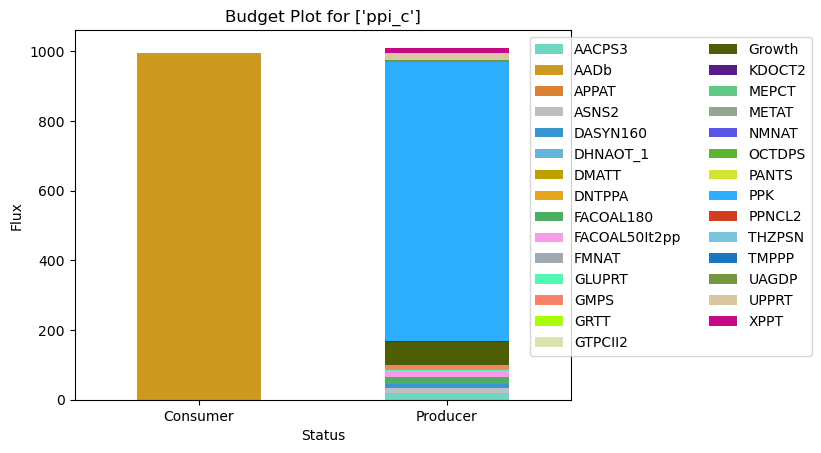

In [235]:
budget_plot = make_budget_plot(all_reactions)
budget_plot